## Load Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer
import torch
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

/Users/alekhya/anaconda3/envs/fakenews/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read the datasets
true_df = pd.read_csv("News _dataset/True.csv")
fake_df = pd.read_csv("News _dataset/Fake.csv")

# Add labels 
true_df['label'] = 1
fake_df['label'] = 0

# Combine and shuffle datasets
df = pd.concat([true_df, fake_df]).sample(frac=1).reset_index(drop=True)

# Use only title+text for classification
df['content'] = df['title'] + ' ' + df['text']

display(df.head())

# Split 
train_text, val_text, train_label, val_label = train_test_split(df['content'], df['label'], test_size=0.2, random_state=42)

,title,text,subject,date,label,content
0,"Fincantieri, Naval Group may exchange stakes i...",MILAN (Reuters) - Italy s Fincantieri and Fran...,worldnews,"September 28, 2017",1,"Fincantieri, Naval Group may exchange stakes i..."
1,WATCH: Celebrities Unite To Send POWERFUL Mes...,December 19th could be the day 38 electors ste...,News,"December 14, 2016",0,WATCH: Celebrities Unite To Send POWERFUL Mes...
2,HILARIOUS! TRUMP SUPPORTER Uses Berkeley Riot ...,Pepsi got hammered by just about everyone for ...,politics,"Apr 15, 2017",0,HILARIOUS! TRUMP SUPPORTER Uses Berkeley Riot ...
3,House to unveil Obamacare bill after next week,WASHINGTON (Reuters) - Republican lawmakers pl...,politicsNews,"February 16, 2017",1,House to unveil Obamacare bill after next week...
4,Trump returns to hardline position on illegal ...,PHOENIX (Reuters) - Republican presidential no...,politicsNews,"September 1, 2016",1,Trump returns to hardline position on illegal ...


## EDA

title      0
text       0
subject    0
date       0
label      0
content    0
dtype: int64
label
0    23481
1    21417
Name: count, dtype: int64


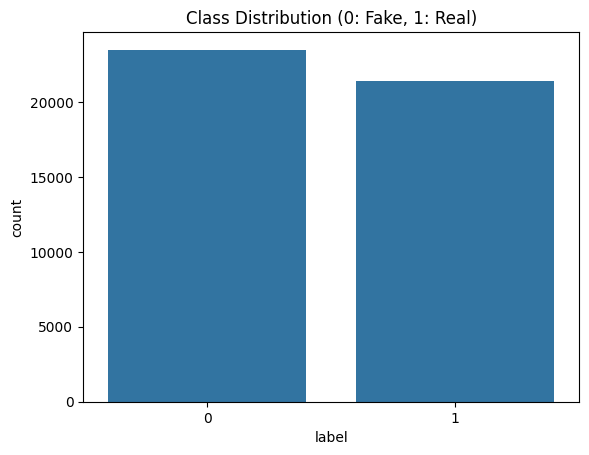

In [3]:
# Check for nulls
print(df.isnull().sum())

# Check class imbalance
print(df['label'].value_counts())

sns.countplot(x="label", data=df)
plt.title("Class Distribution (0: Fake, 1: Real)")
plt.show()

No null values.

Classes are not too imbalanced!

## Tokenize with BERT Tokenizer

In [4]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(
    list(train_text), truncation=True, padding=True, max_length=512
)

val_encodings = tokenizer(
    list(val_text), truncation=True, padding=True, max_length=512
)

## Create Dataset Objects

In [5]:
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, label):
        self.encodings = encodings
        self.label = label
    def __len__(self):
        return len(self.label)
    def __getitem__(self, idx):
        return {
            key: torch.tensor(val[idx]) for key, val in self.encodings.items()
        } | {"labels": torch.tensor(self.label[idx])}

train_dataset = NewsDataset(train_encodings, list(train_label))
val_dataset = NewsDataset(val_encodings, list(val_label))



## Fine-Tune BERT

In [7]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

training_args = TrainingArguments(
    output_dir="./results", 
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    logging_dir="./logs",
    logging_steps=10
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RuntimeError: MPS backend out of memory (MPS allocated: 8.86 GB, other allocations: 194.67 MB, max allowed: 9.07 GB). Tried to allocate 192.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

## Visualize Training and Validation Accuracy

In [ ]:
# Extract metrics
train_acc = [x['eval_accuracy'] for x in trainer.state.log_history if 'eval_accuracy' in x]
eval_steps = [x['step'] for x in trainer.state.log_history if 'eval_accuracy' in x]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(eval_steps, train_acc, label="Validation Accuracy")
plt.xlabel("Training Steps")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy over Time")
plt.legend()
plt.show()

